# Анализ поведения пользователей мобильного приложения

## Описание исследования

Анализ выполняется для мобильного приложения "Ненужные вещи", в рамках которого пользователи создают объявления о продаже тех или иных предметов. Функционал приложения - классический вараинт приложения по продвижению объявлений (поиск по разным фильтрам, рекомендации, просмотр фото, добавление в избранное), включает возможность дополнительного продвижения объявлений.

Целевым действием принимается "просмотр контактов", так как достоверным образом определить, что пользователь связался с владельцем объявления невозможно.

В рамках исследования нам предоставлены данные о пользователях и совершаемых ими действиях в приложении за период с 7 октября 2019 г. по 3 ноября 2019 г. 

### Цель исследования

Основной целью исследования является анализ поведения пользователей в приложении и определение того, какие факторы влияют на совершение целевого действия.

### План анализа

1. Введение, описание исследования и определение целей 
2. Выгрузка и предварительная обработка данных:
    - Выгрузка и объединение данных из двух таблиц
    - Приведение датафреймов к унифицированному виду
    - Обработка значений в столбцах: приведение к нужному типу данных, унификация значений
3. Исследовательский анализ данных:
    - Определение основных действий пользователей в приложение
    - Оценка распределения пользователей по источникам, коэффициент удержания источников и зависимости совершаемых действий от источника
    - Оценка месячной и суточной активности пользователей в приложении
4. Анализ основных вопросов исследования:
    - Определение пользовательской сессии, анализ пользовательского пути и определение наиболее частых путей до целевого действия
    - Анализ разницы между пользователями, которые совершают и не совершают целевых действий
    - Проверка выдвинутых гипотез:
    1. Гипотезы о равенстве конверсии в целевое действия между пользователями, которые только смотрят рекомендации, и теми, кто на них кликает.
    2. Гипотеза о том, что конверсия в целевое действие у тех пользователей, которые пользуются поиском выше, чем у остальных.
5. Заключение и рекомендации
    

## Загрузка и предварительная обработка данных

### Загрузка

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
from tqdm import tqdm
from plotly.subplots import make_subplots
from scipy import stats as st
pd.options.mode.chained_assignment = None

In [62]:
sources = pd.read_csv('C:/Users/Aia/Desktop/mobile_sources.csv')
dataset = pd.read_csv('C:/Users/Aia/Desktop/mobile_dataset.csv')

### Общая информация о датасетах

In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


- В датастете с данными о польльзовательских действия 74 тыс. строк и отсутствуют пропуски.
- Тип данных в столбце `event.time` не соответствует заявленному типу.

 Посмотрим теперь на данных об источниках.

In [64]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


- В данном датасете строк существенно меньше, пропуски также отсутствуют.
- Названия столбцов не унифицированы - желательно привести их к единому виду.

При объединении мы сможем определить для всех ли пользователей из первого датасета есть информация об источнике привлечения и на основании этого сделать вывод о том, как соотносятся эти два набора данных.

### Предварительная обработка

#### Приведение названия столбцов к унифицированному виду

Приведем названия столбцов к единому стилю для удобства дальнейшей работы. Используем `snake_case`.

In [65]:
dataset.columns = ['event_time', 'event_name', 'user_id']

In [66]:
sources.columns = ['user_id', 'source']

#### Тип данных

Приведем данные в столбце `event_time` к типу datetime.  

In [67]:
dataset['event_time'] = pd.to_datetime(dataset['event_time'], format=('%Y-%m-%d %H:%M:%S'))

### Аномальные значения в столбцах
Посмотрим на уникальные значения в категориальных столбцах, а также на распределение дат в столбце `event_time`.

In [68]:
dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Здесь у нас встречаются различные подкатегории поиска `search_1`, `search_2` и пр., которые можно укрупнить в единую категорию. \
Кроме того, категории `contact_show` и `show_contacts` - это одна категория, то есть требуется привести их к одному виду, что мы и сделаем ниже.

In [69]:
dataset['event_name'] = dataset['event_name'].replace('show_contacts', 'contacts_show')

Создадим дополнительный столбец `event_cat`, в который войдут все значения из столбца `event_name`, а все значения поиска будут объеденены в одну категорию `search`.

In [70]:
dataset['event_cat'] = dataset['event_name']
dataset.loc[dataset['event_cat'].str.contains('search'), 'event_cat'] = 'search'

In [71]:
dataset['event_time'].describe(datetime_is_numeric=True)

count                            74197
mean     2019-10-21 15:32:09.039316992
min         2019-10-07 00:00:00.431357
25%      2019-10-14 22:04:27.791869952
50%      2019-10-22 00:26:56.715014912
75%      2019-10-28 12:35:53.023877120
max         2019-11-03 23:58:12.532487
Name: event_time, dtype: object

Все значения представлены за период с 7 октября 2019 года по 3 ноября 2019 г. и охватывают ровно 4 недели.


In [72]:
sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

В столбце с источниками предсталены три категории и нет аномальных значений.

### Дубликаты

Посмотрим, нет ли в данных дубликатов.

In [73]:
dataset[dataset.duplicated()]

,event_time,event_name,user_id,event_cat


In [74]:
sources[sources.duplicated()]

,user_id,source


Дубликатов нет, все строки в датафреймах уникальны.

### Объединение столбцов
Объединим датафреймы по id пользователя, проверим, что количество строк совпадает с исходным, а в столбце `source` получившегося датафрейма нет пропусков.

In [75]:
df = dataset.merge(sources, how='left', on='user_id')

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   event_cat   74197 non-null  object        
 4   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.4+ MB


Количество данных в итоговом датафрейме осталось неизменным, а в столбце `source` отсутствуют пропуски - это говорит о том, что данных об источнике привлечения есть для всех пользователей. Также, исходя из количества строк в датасетах, можно предположить, что каждый привлеченный пользователь совершает достаточно много действий в приложении.

## Исследовательский анализ данных

### Анализ пользовательских действий

Для начала определим, какие действия совершаются пользователями в приложении чаще всего. Можно предположить, что одним из самых популярных действие будет поиск, так как именно он позволяет обнаружить интересующую вещь, далее открытие карточки объявление и просмотр фото - это стандартная цепочка событий при поиске какого-либо предмета.

In [77]:
sns.set_palette('muted')
sns.set_style('darkgrid')

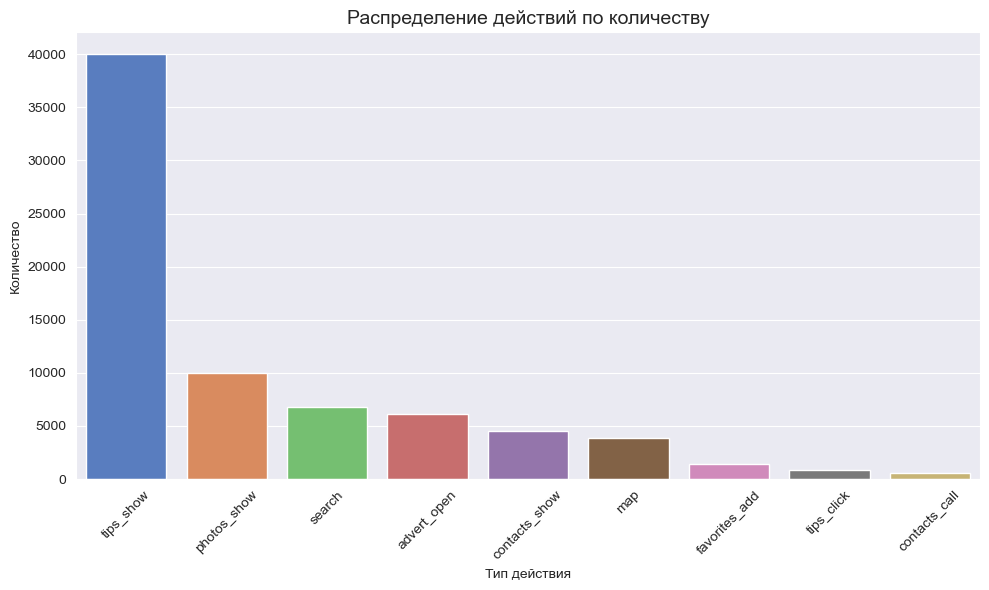

In [78]:
fig = plt.figure(figsize=(10,6))

event_cnt_bar = (
    sns.barplot(data=df.groupby('event_cat', as_index=False).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False),
                 x='event_cat',
                 y='user_id')
)
for item in event_cnt_bar.get_xticklabels():
    item.set_rotation(45)
plt.title('Распределение действий по количеству',
         fontsize=14)
plt.xlabel('Тип действия')
plt.ylabel('Количество')


fig.tight_layout()
plt.show();

Вопреки ожиданиям самым популярным действием оказался не поиск, а просмотр рекомендаций, причем с очень значительным перевесом. Далее следует просмотр фото и лишь затем поиск.

О чем это говорит? В первую очередь, можно предположить, что пользователи чаще использует приложение не для поиска конкретных вещей, а просто "скроллят" - возможно, в поисках чего-то интересного для себя, но без определенной цели. Это совпадает и с тем, что доля нажатия на рекомендации очень мала.

Посмотрим отдельно на конверсию из просмотра рекомендаци в клики, часто ли рекомендации находят отклик в пользователях?

In [79]:
tips_conversion = df[df['user_id'].isin(df.loc[df['event_name'] == 'tips_show', 'user_id'])]


tips_conversion['tips_click'] = None
tips_conversion.loc[tips_conversion['event_name'] == 'tips_click', 'tips_click'] = 1

t = tips_conversion.groupby('user_id', as_index=False).agg({'tips_click':'nunique'})
print(f'''Количество `tips_show`: {t['tips_click'].count()}
Количество `tips_click`: {t['tips_click'].sum()}
Конверсия: {round(t['tips_click'].sum()/t['tips_click'].count()*100, 2)}%''')

Количество `tips_show`: 2801
Количество `tips_click`: 297
Конверсия: 10.6%


По уникальным пользователям конверсия из показов в клики составила лишь чуть более 10%, то есть лишь 10% пользователей заинтересовали рекомендации, которые им показывались при использовании приложения.

### Источники привлечения

#### Распределение пользователей по источникам привлечения

Посмотрим дополнительно на распределение пользователей по источникам и на графики времени.

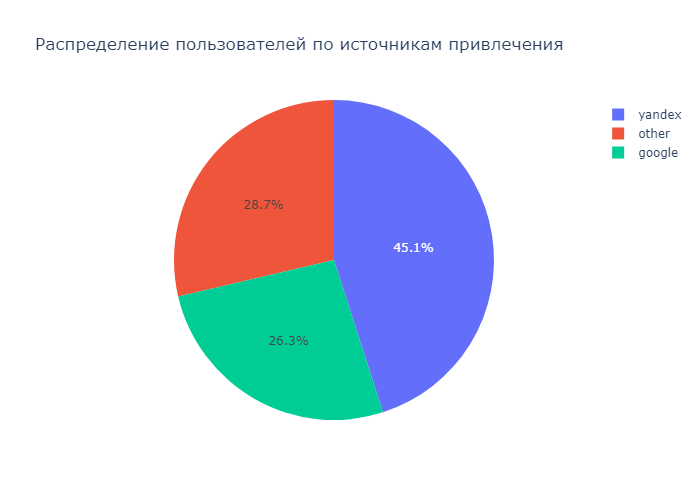

In [80]:
t = df.groupby('source', as_index=False).agg({'user_id':'nunique'})
labels = t['source']
values = t['user_id']

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text="Распределение пользователей по источникам привлечения")
fig.show();

Наибольший процент пользователей пришел через `yandex` - 45,1%, 26,3% - через `google`, а остальные 28,7% попали в приложение через иные источники привлечения.

#### Retention Rate для каждого источника

Оченим коэффициент удержания для каждого источника. 

Так как мы рассматриваем достаточно короткий промежуток времени попробуем дать посуточную оценку.

In [81]:
#Для каждого пользователя определим дату первой активности
first_ts = df.groupby('user_id', as_index=False).agg({'event_time':'min'})
first_ts.columns = ['user_id', 'first_ts']

#Объединим с основным датафреймом по id пользователя
retention_raw = df[['user_id', 'source', 'event_time']].merge(first_ts, how='left', on='user_id')

#Рассчитаем лайфтайм для каждой сессии
retention_raw['lifetime'] = (
    retention_raw['event_time'] - retention_raw['first_ts']
).dt.days

retention_raw.head(5)

,user_id,source,event_time,first_ts,lifetime
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431357,2019-10-07 00:00:00.431357,0
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01.236320,2019-10-07 00:00:00.431357,0
2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02.245341,2019-10-07 00:00:02.245341,0
3,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07.039334,2019-10-07 00:00:00.431357,0
4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:56.319813,2019-10-07 00:00:02.245341,0


In [82]:
#Построим треугольную таблицу удержания
retention_grouped = retention_raw.pivot_table(
    index=['source'], columns='lifetime', values='user_id', aggfunc='nunique'
)

#Вычисляем размеры когорт

cohort_sizes = (
    retention_raw.groupby('source')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

#Добавляем размер когорты в треугольную таблицу
#Пропуски заполняем 0
retention_grouped = cohort_sizes.merge(
    retention_grouped, on='source', how='left'
).fillna(0)

#Делим данные таблицы удержания на размеры когорт
retention_grouped = retention_grouped.div(
    retention_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size', 0])

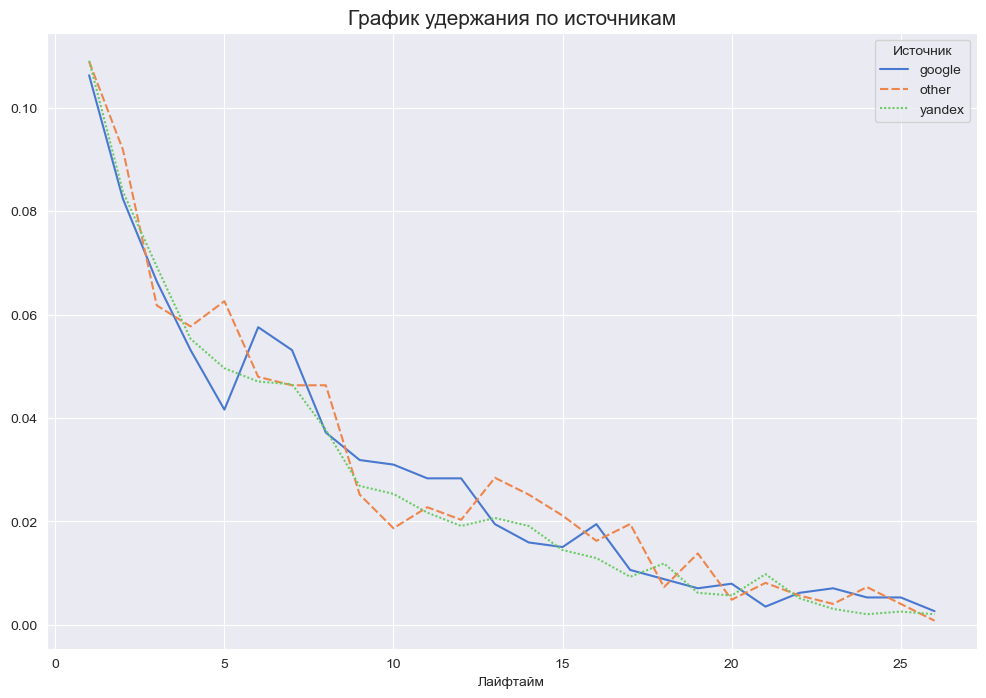

In [83]:
plt.figure(figsize=(12,8))

ax = sns.lineplot(data = retention_grouped.T)
ax.set_title('График удержания по источникам',
            fontsize=15)
ax.set_xlabel('Лайфтайм')
ax.legend(title='Источник')
plt.show();

- Как видно на графике, какой-то заметной разницы между источниками нет. Коэффициент удержания для каждого источника находится примерно на одном уровне.
- Доля ползователей значительно падает, начиная уже с первого дня, продолжая снижаться далее со временем. В целом это не противоречит основной задаче приложение. Приложение предназначено для выполнения конкретной задачи, поэтому не предполагает ежедневной пользовательской активности. 

#### Распределение количество действий по типу источника

Посмотрим, сохраняется ли пропорция между пользователями разных источников по количеству действий.

In [84]:
graph_data = (df.groupby(['event_cat', 'source'], as_index=False)
              .agg({'user_id':'count'})
              .rename(columns={'user_id':'cnt'})
              .sort_values(by=['cnt'], ascending=False))
total_by_cat = df.groupby('event_cat').agg({'user_id':'count'}).rename(columns={'user_id':'total_cnt'})
graph_data = (
    graph_data
    .merge(total_by_cat, how='left', on='event_cat')
    .sort_values(by=[ 'source', 'total_cnt'], ascending=False)
    .reset_index(drop=True)
)
graph_data['percentage'] = round(graph_data['cnt']/graph_data['total_cnt']*100, 2)

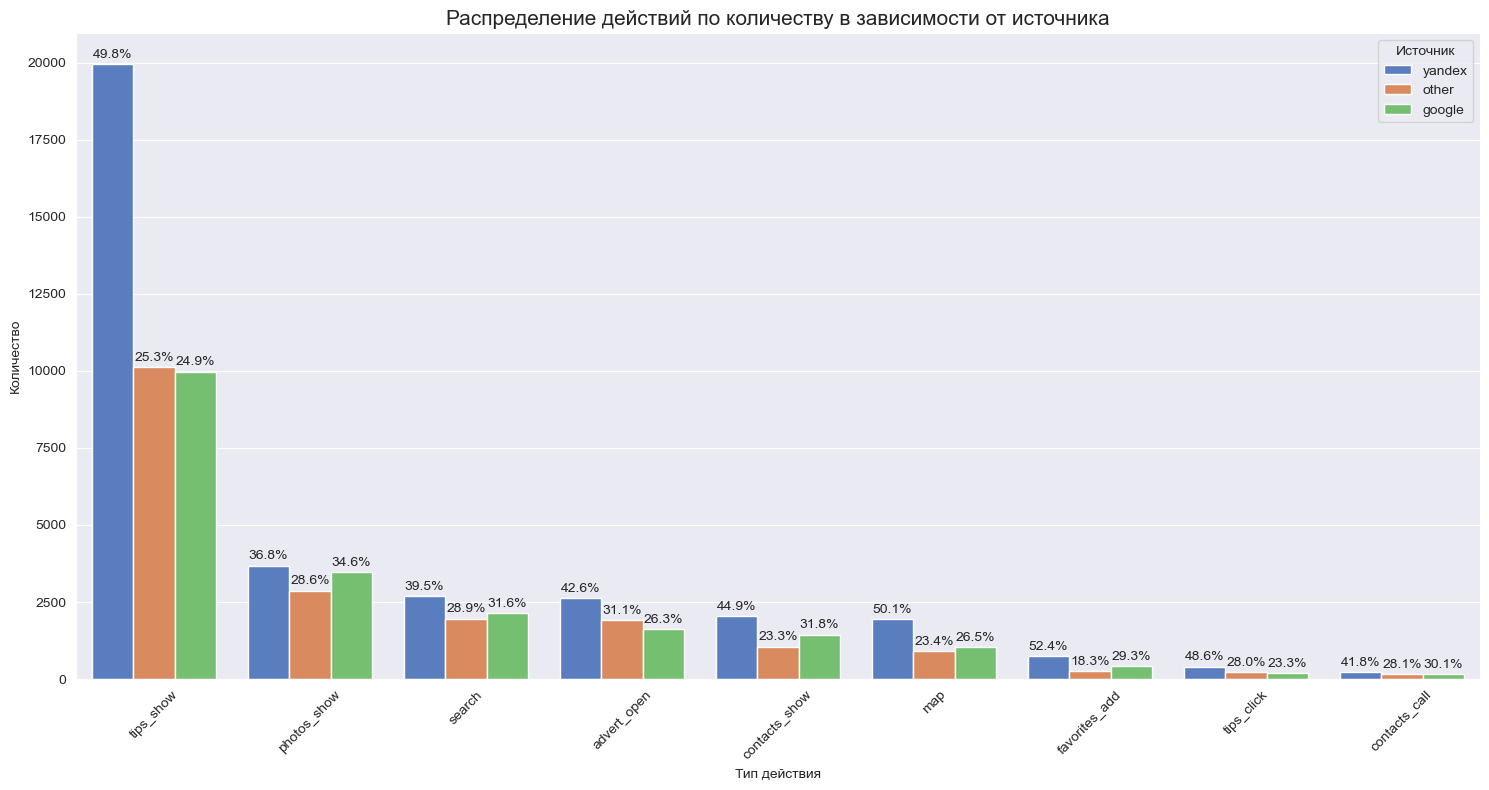

In [85]:

fig = plt.figure(figsize=(15,8))
text=graph_data['percentage']

ax = (
    sns.barplot(data= graph_data,
                 x='event_cat',
                 y='cnt',
                 hue='source')
)
for item in ax.get_xticklabels():
    item.set_rotation(45)
    
for n,p in enumerate(ax.patches):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h + 500)
    text = f'{graph_data.loc[n,"percentage"]:0.1f}%'
    ax.annotate(text=text, xy=xy, ha='center', va='top')    

ax.legend(title='Источник')

plt.title('Распределение действий по количеству в зависимости от источника', 
         fontsize=15)
plt.xlabel('Тип действия')
plt.ylabel('Количество')


fig.tight_layout()
plt.show();

- По количеству показов рекомендаций пользователи, привлеченные яндексом, в два раза опережают остальные группы. Это в целом согласуется с общим распределением пользователей по источникам. Примерно в такой же пропорции они опережают остальных пользователей по количеству просмотров контаков и открытию карты.
- Пользователи из гугла часто просматривают фото, почти наравне с пользователями из яндекса (34,6% против 36,8%), и чаще, чем пользователи из других источников. При этом они также значительно чаще пользователей из других источников просматривают контакты (31,8% против 23,3%), хотя изначально пропорция количества пользователей - в пользу второй группы.
- Пользователи из других источников, хоть и превосходят по количеству пользователей из гугла, по большинству действий проигрывают этой группе (исключение составляют лишь открытия объявлений и нажатие на рекоемндации). Возможно, это свидетельствуют об их меньшей активности в приложении.

### Пользовательская активность по времени

#### Распределение пользователей по датам активности в приложении

Посмотрим, как оказались распределены пользователи по датам в течение месяца, есть ли какие-то паттерны или аномалии. Для построения графика возьмем количество уникальных пользователей для каждого анализируемого дня - таким образом мы избежим возникновения аномально высоких значений в тех случаях, когда пользователи смотрели объявления с большими колчиеством фото или просто скроллили приложение.

In [86]:
df['event_date'] = df['event_time'].dt.date

In [87]:
daily_unique_users = df.groupby('event_date', as_index=False).agg({'user_id':'nunique'})
daily_unique_users.columns = ['event_date', 'user_cnt']
daily_unique_users['user_cnt'] = daily_unique_users['user_cnt'].rolling(3).mean()

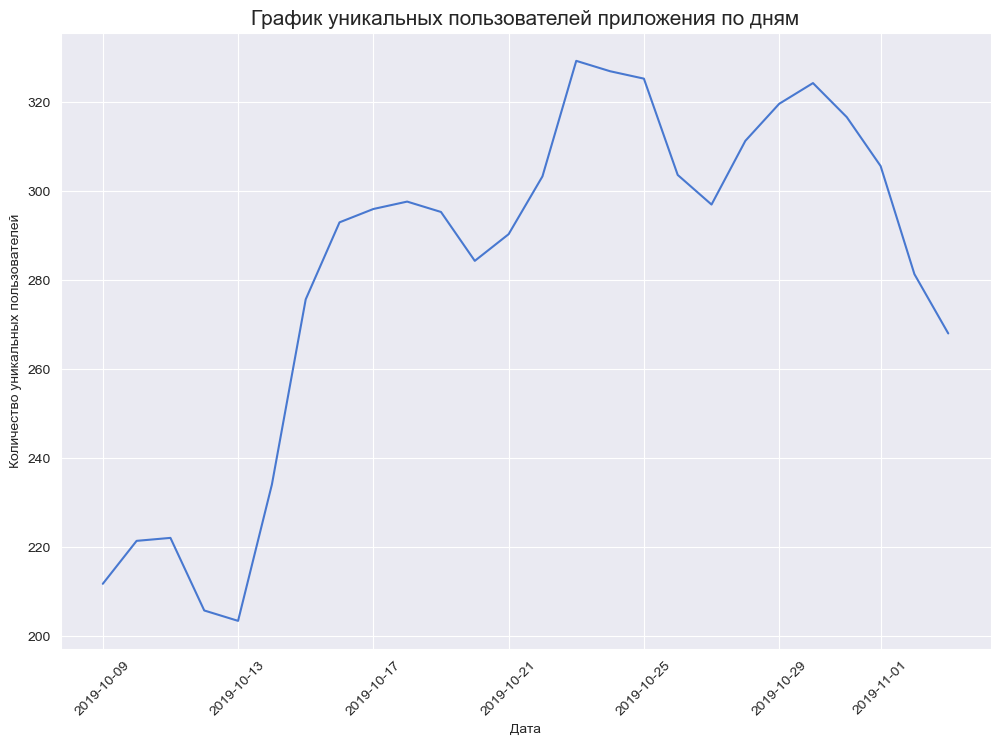

In [88]:
plt.figure(figsize= (12,8))
activity_plot = (sns.lineplot(
    data = daily_unique_users,
    x='event_date',
    y='user_cnt'
))
for item in activity_plot.get_xticklabels():
    item.set_rotation(45)
    
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей')
plt.title('График уникальных пользователей приложения по дням',
         fontsize=15);



В первые пять дней пользовательская активность была существенно ниже, чем в остальной период - в приложении совершали действие примерно на 100 человек в день меньше. Таким образом, либо увеличивалось количество привлеченных пользователей, либо привлеченные пользователи заходили в приложение повторно.

Посмотрим, как менялась пользовательская активность в течение дня. Для наблюдения паттернов возьмем данные понедельно. 

In [89]:
date_time_activity = df.loc[:,['event_time', 'user_id']]
date_time_activity['date'] = df['event_time'].dt.date
date_time_activity['hour'] = df['event_time'].dt.hour
date_time_activity['week'] = df['event_time'].dt.isocalendar().week

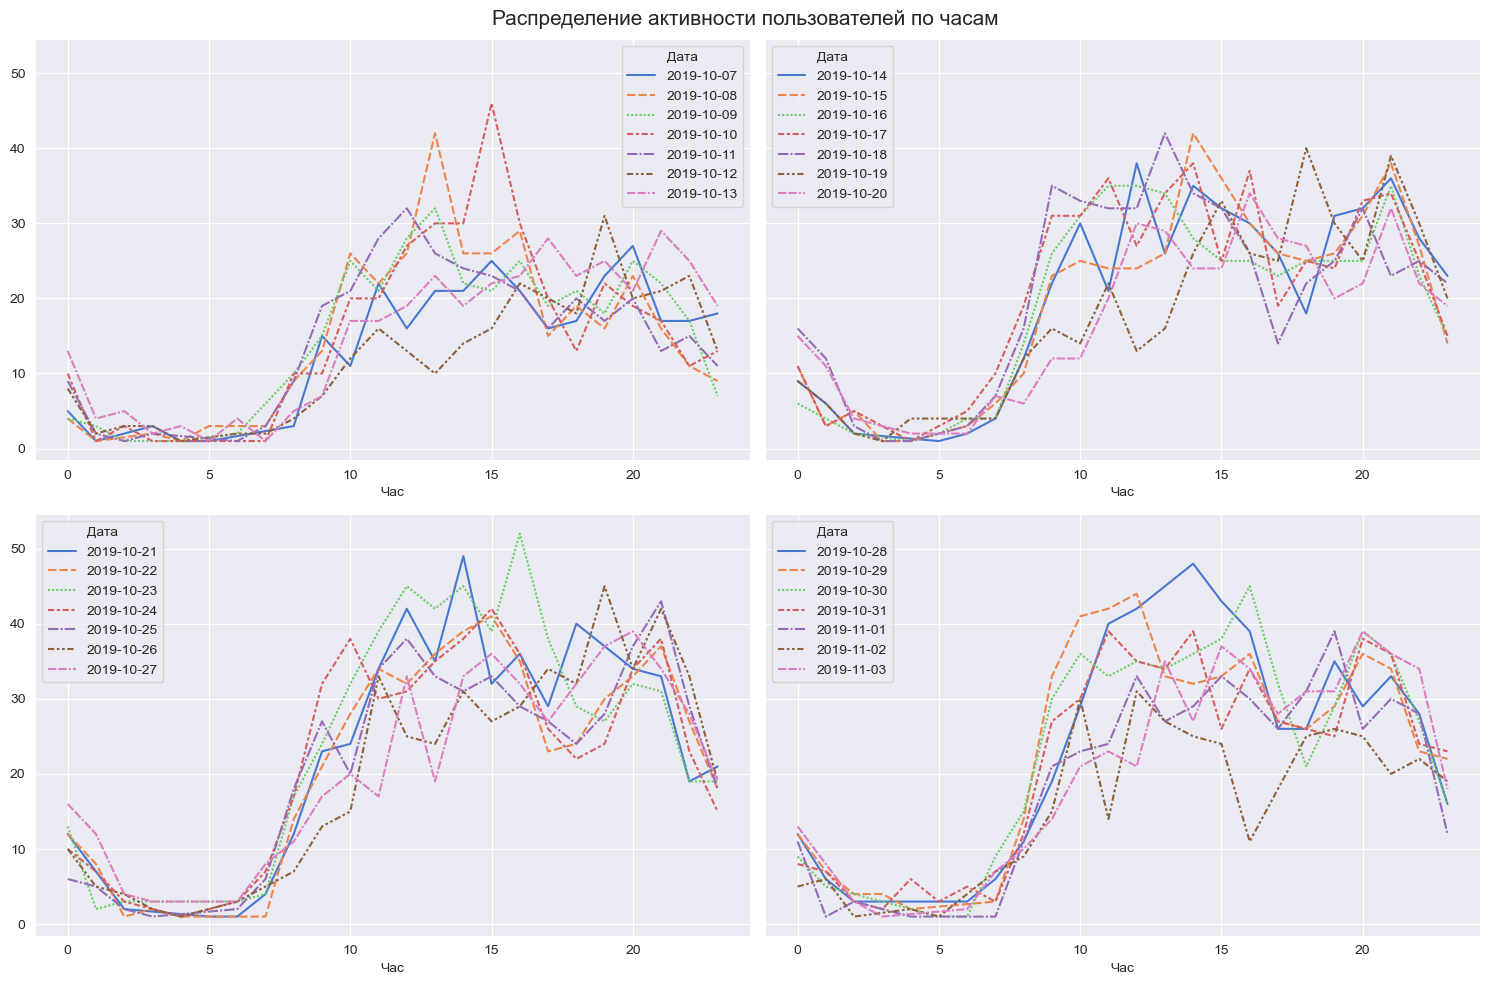

In [90]:
fig, ax = plt.subplots(2,2, sharey=True, figsize=(15, 10))

ax = np.ndarray.flatten(ax)

for n, week in enumerate(date_time_activity['week'].unique()):
    t = (
        date_time_activity[date_time_activity['week']== week]
        .pivot_table(index='date', columns='hour', values='user_id', aggfunc='nunique')
    )
    
    sns.lineplot(data = t.T,
                       ax=ax[n]),
    ax[n].set_xlabel('Час')
    ax[n].legend(title='Дата')

    
fig.suptitle('Распределение активности пользователей по часам',
            fontsize=15)
fig.tight_layout()
plt.show()

Суточная активность пользователей в целом сопоставима с обычным режимом дня - минимальная в ночное время, с повышением в утренние часы и пиком в дневное время.

### Выводы

- Основным действие в приложении является показ рекомендаций - он в 4 раза превышает следующее по частоте действие - покащ фотографий. Это в первую очередь связано с тем, что данное действие является автоматическим показом польлзователю рекомендации, однако оно может свидетельство и о том, что пользователи просто "скроллят" рекомендации. 
- Отклик на рекомендации у пользователей достаточно низкий: чуть больше 1/10 пользователей, которым былм показаны рекомендации, действительно заинтересовались ими.
- Основная масса пользователей за рассматриваемый период попала в приложение через "Яндекс", на втором месте иные источники, а на третьем "Гугл". При этом пользователи из "Гугла" просматривают много фотографий - почти наравне с яндексом, и по многим действиям опережают пользователей из других источников. Можно предположить, что пользователи из других источников в целом менее активны в приложении.
- Никакой взаимосвязи удержания и источника привлечения не выявлено: коэффициент удержания одинаково для всех источников резко падает в первый же день, что в целом согласуется с задачами приложения.
- На временном графике никаких аномалий также не выявлено. После первой недели наблюдается в целом подъем активности в приложении, что скорее всего связано с появлением все новых пользователей и повторным использованием приложения.
- Суточный график активности в целом соотносится с обычным поведением пользователей: минимальная активность в ночное время суток и подъем в дневное. Никаких неожиданных пиков и отклонений не выявлено.

## Основные вопросы исследования

### Анализ пользовательского пути и связи целевого действия с прочими.

#### Пользовательские сессии

Определим расстояниями между действия пользователей в приложении, посмотрим на наиболее типичные, а также на аномально высокие. На основании этого попытаемся определить время таймаута сессии и вычислить пользовательские сессии.

In [91]:
df['time_diff'] = df.sort_values(by=['user_id','event_time']).groupby('user_id')['event_time'].diff().dt.seconds / 60

In [92]:
df['time_diff'].describe()

count    69904.000000
mean        48.808948
std        209.831209
min          0.000000
25%          0.383333
50%          1.166667
75%          3.000000
max       1439.716667
Name: time_diff, dtype: float64

В 75% случаев между действиями пользователей в приложении происходит менее 3 минут. Можно практически с уверенностью утверждать, что данные действия происходят в рамках одной пользовательской сессии. 

При этом разброс очень большой. В основной массе расстояние между действиями лишь немногим больше 0. Посмотрим на отрезок в рамках одного часа (60 минут).

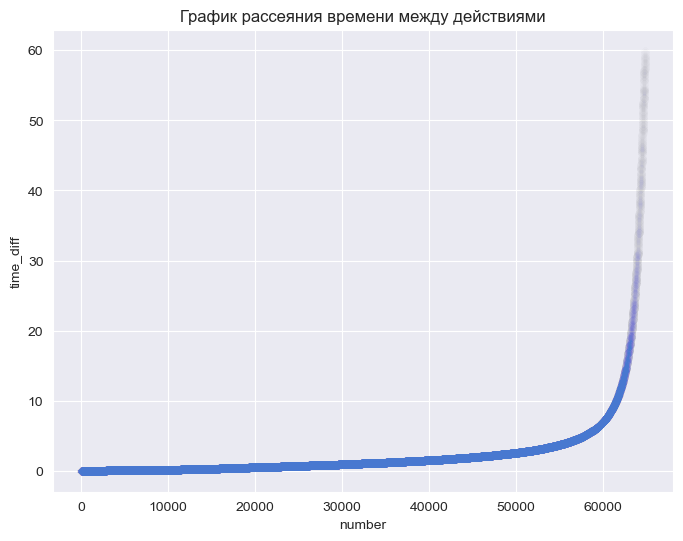

In [93]:
plt.figure(figsize=(8,6))
t = pd.DataFrame({'number':range(len(df[df['time_diff']<=60])),
             'time_diff':df.loc[df['time_diff']<=60, 'time_diff'].sort_values()})
sns.scatterplot(data=t,
                x='number',
                y='time_diff',
               alpha=.003)
plt.title('График рассеяния времени между действиями');

Примем отметку в 90% за предел времени между действиям, так как в большинстве случаев рассматриваемое нами расстояние - расстояние между действиями. Тогда все, что окажется за этим пределом, будет рассматриваться как таймаут сессии.

In [94]:
time_limit = np.nanpercentile(df['time_diff'], 90)

In [95]:
g = (df.sort_values(by=['user_id','event_time'])
     .groupby('user_id')['event_time'].diff() >
     pd.Timedelta(time_limit, unit='min')).cumsum()

df['session_id'] = (df.sort_values(by=['user_id','event_time'])
                    .groupby(['user_id', g], sort=False)
                    .ngroup() + 1)

#### Определение пользовательского пути в приложении

На основании сессий построим диаграмму Санкея, на которой отобразим потоки прохождения пользователей в мобильной приложении. Посмотрим, какие действия чаще всего совершаеют пользователи, как выглядит пользовательский путь к целевому действию.

При построении диаграммы мы будем использовать столбец `event_cat`, то есть учитывать поиск в целом, а не отдельные фильтры. Для работы исключим строки `tips_show`, так как данное действие является автоматическим и не ведет к целевому действию, а также повторяющиеся действия в рамках сессии. Рассмотрим первые пять шагов пользовательского пути.

In [96]:
# Подготовим данные для построения диаграммы

customer_journey = (
    df.loc[~(df['event_cat']=='tips_show'), ['user_id', 'event_time','event_cat', 'session_id']]
    .sort_values(by=['user_id','event_time'])
)

# Добавим столбцы с исходным и целевым действием
customer_journey['source_event'] = customer_journey['event_cat'] 
customer_journey['target_event'] = customer_journey.groupby('session_id')['event_cat'].shift(-1)

# Исключим лишние столбец и строки
customer_journey = customer_journey.drop('event_cat', axis=1)
customer_journey = customer_journey[~(customer_journey['source_event'] == customer_journey['target_event'])]

#Проунмеруем каждый шаг пользователя в сессии
customer_journey['step'] = customer_journey.groupby('session_id').cumcount() + 1

# Посмотрим, сколько уникальных шагов совершают пользователи в сессию

unique_steps = (
    customer_journey
    .groupby('step', as_index=False)
    .agg({'session_id':'nunique'})
    .rename(columns={'session_id': 'cnt'})
)
unique_steps['total'] = len(customer_journey['session_id'].unique())
unique_steps['perc'] = unique_steps['cnt']/unique_steps['total']*100 

unique_steps.head(10)

,step,cnt,total,perc
0,1,8252,8252,100.000000
1,2,3113,8252,37.724188
2,3,1450,8252,17.571498
3,4,817,8252,9.900630
4,5,444,8252,5.380514
5,6,284,8252,3.441590
6,7,179,8252,2.169171
7,8,131,8252,1.587494
8,9,94,8252,1.139118
9,10,68,8252,0.824043


Меньше пяти процентов сессий состоят из более, чем 5 шагов, поэтому возьмем 5 шагов за границу и посмотрим пользовательский путь для 95% сессий.

In [97]:
customer_journey_filtered = customer_journey[customer_journey['step'] <= 5]

In [98]:
def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source_event'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(customer_journey_filtered)

In [99]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [100]:
def colors_for_sources():
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    
    for label in customer_journey_filtered['source_event'].unique():
        r, g, b = np.random.randint(255, size=3)            
        colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    return colors_dict
  
  
# генерю цвета из своего списка
colors_dict = colors_for_sources()

In [101]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [102]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(customer_journey_filtered['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = customer_journey_filtered[(customer_journey_filtered['step'] == step)&
                                      (customer_journey_filtered['source_event'] == source)&
                                      (customer_journey_filtered['target_event'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


In [103]:
def plot_sankey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, width=3000, height=1200)
    fig.update_layout(
        autosize=False,
        width=1000,
        height=800,             
    )
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
sankey_diagram = plot_sankey_diagram()

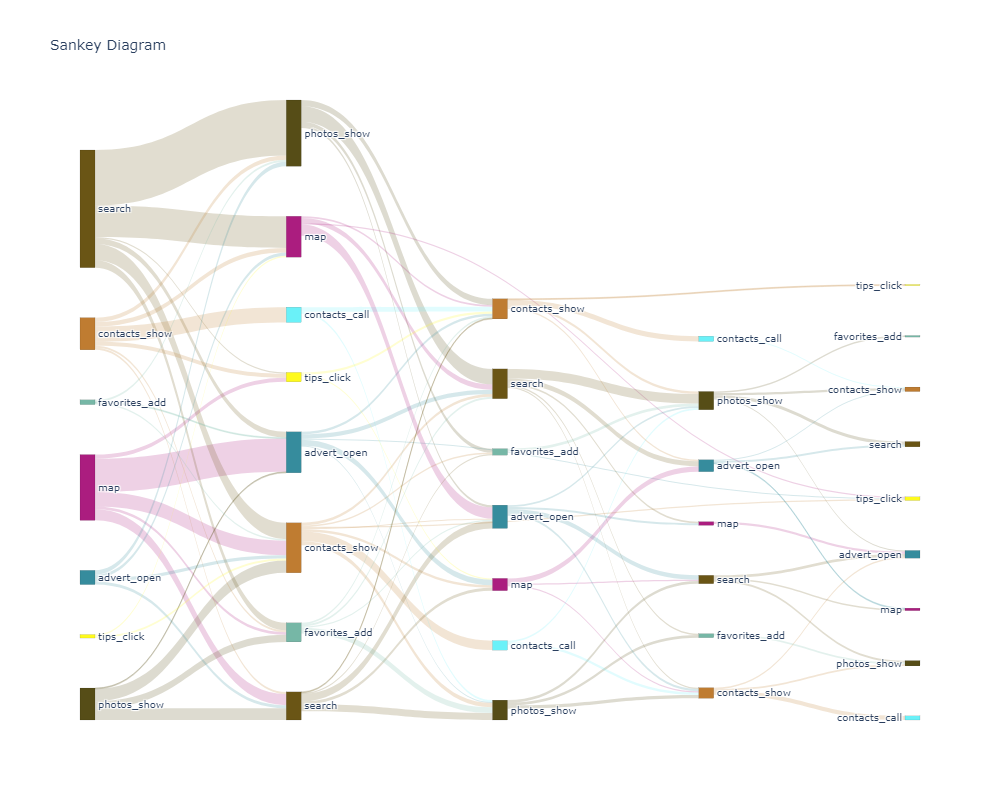

In [104]:
sankey_diagram.show()

- Обратим внимание, что количество сценариев оказалось существенно меньше, чем количество сессий и даже польщователей. Это скорее всего связано с исключением действия `target_show` из выборки. Таким образом можно предположить, что некоторые пользователи действительно просто просматривают рекомендации во время своей сессии, не совершая других действий.
- В большинстве случаев пользовательский путь начинается с поиска. Следующее по популярности действие - просмотр карты объявлений, затем следует показ контактов/фото/открытие объявлений - все эти действия могут являться следствием возвращения на то же место, на котором в прошлый раз закончилась пользовательская сессия или переходом по ссылке, совсем редко первым действием оказывается добавление в избранное или нажатие на рекомендации.
- Наиболее частый пользовательский путь состоит из поиска - просмотра фото, причем зачастую пользователи оказываются неудовлетворены выбором - сессия прекращается либо пользователь возвращается к фото.
- Следующие по популярности: поиск - открытие карты - открытие объявления, открытие карты - открытие объявления.
- Для каждого шага доля пользователей, совершающих целевое действие составляет порядка 10%. 

#### Пользовательский путь до целевого действия

Посмотрим на наиболее характерный пользовательский путь, который приводит к целевому действию.

In [105]:
#Создадим функцию для создания таблицы пользовательского пути с фильтром
#В качестве аргументов - название датафрейма, столбец, по которому фильруем, значение для фильтра
def journey_table (df, col, target_val):
    
    #определяем сессии с целевым действием
    target_sessions = df.loc[df[col] == target_val, 'session_id']
    
    #группируем действия для каждой сессии, попавшей в фильтр
    journey_by_sessions = (
     df[df['session_id']
    .isin(target_sessions)].groupby('session_id')
    .agg({col: lambda x: tuple(x)})
    .reset_index()
    )
    
    #считаем количество сессий с каждым из сценариев
    cnt_table = (
    journey_by_sessions.groupby(col)
    .agg({'session_id':'nunique'})
    .sort_values(by='session_id', ascending=False)
    .reset_index()
    )

    cnt_table.columns = ['journey', 'sessions_cnt']
    return cnt_table

journey_table(customer_journey, 'source_event', 'contacts_show').head(15)

,journey,sessions_cnt
0,"(contacts_show,)",726
1,"(map, contacts_show)",134
2,"(contacts_show, contacts_call)",92
3,"(search, contacts_show)",87
4,"(photos_show, contacts_show)",52
5,"(search, contacts_show, contacts_call)",35
6,"(contacts_show, map)",28
7,"(photos_show, contacts_show, photos_show)",26
8,"(contacts_show, photos_show)",25
9,"(contacts_show, contacts_call, contacts_show, ...",23


- Как это ни странно наиболее часто сессия с целевым действием состоит из одного целевого действия - просмотра контактов или просмотра контактов + звонок: скоре всего это тот случай, когда сессия либо открывалась с предыдущего места, либо переход на контакты осуществлялся по ссылке, либо из рекомендаций.

- Кроме того часто пользовательская сессия с целевым действием состоит из следующих шагов: просмотр карты + просмотр контактов / поиск + просмотр контактов / просмотр фото + просмотр контактов.

Дополнительно посмотрим на объем сессий, которые состояли только из просмотра рекомендаций.

In [106]:
journey_table(df, 'event_cat', 'tips_show').head()

,journey,sessions_cnt
0,"(tips_show,)",1108
1,"(tips_show, tips_show)",456
2,"(tips_show, tips_show, tips_show)",305
3,"(tips_show, tips_show, tips_show, tips_show)",260
4,"(tips_show, tips_show, tips_show, tips_show, t...",200


Из всех пользовательских сессий более 2,5 тыс. состояли только из просмотра рекомендаций. Это подтверждает предположение о том, что пользователи просто "скроллят" приложение в поисках чего-то интересного.

Таким образом, **наиболее популярными путями к целевому действию** являются:
1. Поиск - просмотр контактов
2. Открытие карты - просмотр контактов
3. Просмотр фото - просмотр контактов
4. Открытие объявления - просмотр контактов
5. Поиск - просмотр фото - просмотр контактов
6. Нажатие на рекомендации - просмотр контактов

Поистроим воронки для этих сценариев для уникальных пользователей. Для начала построим воронки для двухступеньчатых сценариев и сравним их между собой.

In [107]:
def two_step_funnel(df, step_1, target):
    funnel_sessions = customer_journey.query('step == 1 and source_event == @step_1')['session_id']
    
    funnel_cnt = (
    customer_journey
    .query('session_id in @funnel_sessions')
    .groupby(['step', 'source_event'])
    .agg({'user_id':'nunique'})
    .reset_index()
    )
    
          
    return funnel_cnt.query('step == 1 or (step == 2 and source_event == @target)')
    

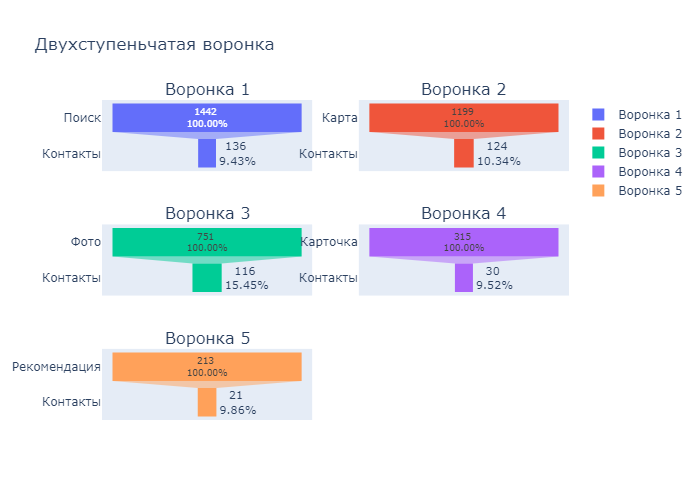

In [108]:
search_funnel = two_step_funnel(customer_journey, 'search', 'contacts_show')
map_funnel = two_step_funnel(customer_journey, 'map', 'contacts_show')
photos_funnel = two_step_funnel(customer_journey, 'photos_show', 'contacts_show')
advert_funnel = two_step_funnel(customer_journey, 'advert_open', 'contacts_show')
tips_click_funnel = two_step_funnel(customer_journey, 'tips_click', 'contacts_show')


fig = make_subplots(rows=3, cols=2,
                   subplot_titles=['Воронка 1', 'Воронка 2', 'Воронка 3', 'Воронка 4', 'Воронка 5'])

fig.add_trace(go.Funnel(
        y=['Поиск', 'Контакты'],
        x=search_funnel['user_id'],
        textinfo = "value+percent initial",
        name='Воронка 1'),
              row=1, col=1)

fig.add_trace(go.Funnel(
    y=['Карта', 'Контакты'],
    x=map_funnel['user_id'],
    textinfo = "value+percent initial",
    name='Воронка 2'),
              row=1, col=2)

fig.add_trace(go.Funnel(
        y=['Фото', 'Контакты'],
        x=photos_funnel['user_id'],
        textinfo = "value+percent initial",
        name='Воронка 3'),
        row=2, col=1)

fig.add_trace(go.Funnel(
        y=['Карточка', 'Контакты'],
        x=advert_funnel['user_id'],
        textinfo = "value+percent initial",
        name='Воронка 4'),
        row=2, col=2)

fig.add_trace(go.Funnel(
        y=['Рекомендация', 'Контакты'],
        x=tips_click_funnel['user_id'],
        textinfo = "value+percent initial",
        name='Воронка 5'),
        row=3, col=1)



fig.update_layout(title_text="Двухступеньчатая воронка")
fig.update_traces(texttemplate="%{value:d} <br>%{percentInitial:.2%}")

fig.show()

- В двухступеньчатом сценарии для уникальных наиболее результативным оказывается просмотр карт: 15,1% пользователей переходят сразу к просмотру контактов.
- Второй по результативности - нажатие на рекоменадцию. Из тех, кто совершает это действие - а их количество очень мало - к контакта переходит 10,7%.
- Самые частые действия - поиск и просмотр карты - приводят к целевому действию лишь в 9,4 и 10,3% случаев соответственно.
- Похожей оказалась доля тех, кто просмотрел контакты при открытии объвления - примерно 9,5%. 

In [109]:
search_sessions = customer_journey.query('step == 1 and source_event == "search"')
photos_sessions = customer_journey.query('step == 2 and source_event == "photos_show"')
    
search_funnel_cnt = (
    customer_journey[customer_journey['session_id'].isin(search_sessions['session_id'])]
    .groupby(['step', 'source_event'])
    .agg({'user_id':'nunique'})
    .reset_index()
    )

photos_funnel_cnt = (
    customer_journey[(customer_journey['session_id'].isin(search_sessions['session_id'])) &
                     (customer_journey['session_id'].isin(photos_sessions['session_id']))]
    .groupby(['step', 'source_event'])
    .agg({'user_id':'nunique'})
    .reset_index()
    )


funnel_cnt = pd.concat([search_funnel_cnt.query('step==1'), 
                        photos_funnel_cnt.query('step==2 or (step==3 and source_event == "contacts_show")')],
                        ignore_index=True)

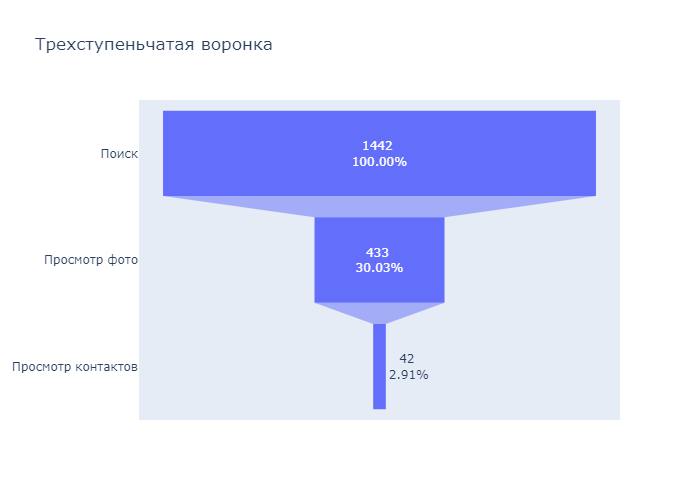

In [110]:
fig = go.Figure(
    go.Funnel(
        y=['Поиск', 'Просмотр фото', 'Просмотр контактов'],
        x=funnel_cnt['user_id'],
        textinfo = "value+percent initial"
    ) 
)
fig.update_layout(title_text='Трехступеньчатая воронка')
fig.update_traces(texttemplate="%{value:d} <br>%{percentInitial:.2%}")
fig.show();

- В трехступеньчатой воронке с поиском и просмотром фото лишь 2,9% от всех пользователей доходят до целевого действия, общий процент от предыдущего шага - 9,7%, что ниже результатов двухступеньчатой воронки дляя просмотра фото.
- Все остальные пути, как следует из диаграммы Санкей и таблицы гораздо менее популярны среди пользователей. Это значит, что самые эффективные пути к целевому действию - короткие.  

#### Выводы:

1. Таймаут сессии наступает примерно через 10-15 мин. неактивности пользователя. В 75% случаев время между действиями на превышает 3 минут.
2. Наиболее типичный пользовательский путь начинается с поиска. Еще одна популярная точка старта - открытие карты. Достаточно много сессий начинаются просмотра фотографий или контактов, - в этих случаях можно предположить, что пользователи вернулись на ту страницу, на которой завершилась предыдущая сессия.
3. Большое количество пользовательских сессий состоят только из просмотра рекомендаций  - можно предположить, что такие пользователи просто скроллят приложение.
4. Самый эффективный путь к целевому действию - самый короткий. Процент пользователей, совершивших целевое действие в двухступеньчатой воронке существенно выше, чем в самой популярной трехступеньчатой.
5. Наибольший процент пользователей, совершивших целевое действие, оказался среди тех пользователей, кто начинал с просмотра фото - 15%, а также кликал на рекомендации или открывал карту - 10,7% и 10,3% соответственно.

### Анализ сессий пользователей, совершающих и не совершающих целевое действие

#### Анализ длительности сессий пользователей

Посмотрим на длительность сессий пользователей, совершающий и несоверщающих целевое действие. Посмотрим, как различался характер этих сессий.

In [111]:
#выделим начало и окончание каждой сессии
session_duration = df.groupby('session_id', as_index=False).agg({'event_time':['min', 'max']})
session_duration.columns = ['session_id', 'session_start', 'session_end']
#определим длительность в мин
session_duration['duration'] = (session_duration['session_end'] - session_duration['session_start']).dt.seconds / 60

#разделим сессии с целевым действием и без него
cs_session_id = df.loc[df['event_cat'] == 'contacts_show', 'session_id']
session_duration['cs_session'] = 0
session_duration.loc[session_duration['session_id'].isin(cs_session_id), 'cs_session'] = 1

In [112]:
t = session_duration.groupby('cs_session').agg({'duration':['mean', 'median']}).reset_index()
t.columns = ['session_type', 'mean_duration', 'median_duration']
t.style.background_gradient(cmap='YlGn', axis=None, subset=['mean_duration', 'median_duration'])

,session_type,mean_duration,median_duration
0,0,9.001816,3.933333
1,1,14.213807,8.016667


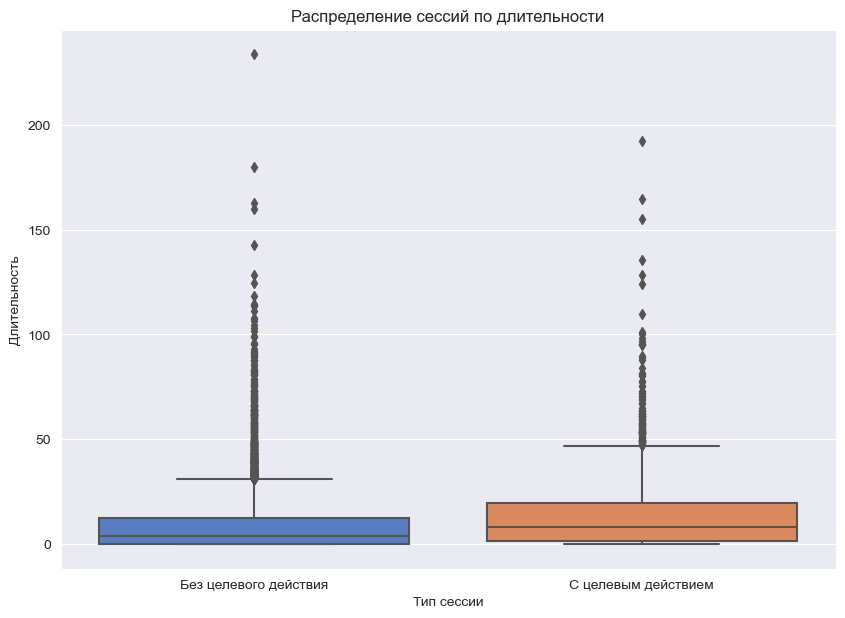

In [113]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(data = session_duration,
           x='cs_session',
           y='duration')
ax.set_xticklabels(['Без целевого действия', 'С целевым действием'])
ax.set_xlabel('Тип сессии')
ax.set_ylabel('Длительность')
ax.set_title('Распределение сессий по длительности');

Пользовательские сессии без целевого действия и в среднем и по медиане оказались короче пользовательских сессий с целевым действием, при этом доля аномально длительных сессий для первой группы кажется больше, чем для второй. 

#### Относительная частота событий

Рассмотрим относительную частоту событий в разрезе двух групп пользователей: тех, кто совершает целевое действие и не совершает его. Разделим пользователей на эти группы и определим, какие действия чаще всего совершает каждая из групп. Отобразим только общие для обеих групп действия (т.е. исключим просмотр контактов и звонок).

In [114]:
cs_user_id = df.loc[df['event_cat'] == 'contacts_show', 'user_id']

cs_user_sessions = df[df['user_id'].isin(cs_user_id)]
non_cs_user_sessions = df[~df['user_id'].isin(cs_user_id)]

cs_users_table = (
    cs_user_sessions
    .groupby('event_cat')
    .agg({'user_id':'count'})
    .rename(columns={'user_id':'cnt'})
    .drop(['contacts_show', 'contacts_call'], axis=0)
    .sort_values(by=('cnt'), ascending=False)
    .reset_index()
)


cs_users_table['perc'] =  cs_users_table['cnt']/ cs_users_table['cnt'].sum() * 100

non_cs_users_table = (
    non_cs_user_sessions
    .groupby('event_cat')
    .agg({'user_id':'count'})
    .rename(columns={'user_id':'cnt'})
    .sort_values(by=('cnt'),  ascending=False)
    .reset_index()
)


non_cs_users_table['perc'] =  non_cs_users_table['cnt']/ non_cs_users_table['cnt'].sum() * 100

cs_users_table

,event_cat,cnt,perc
0,tips_show,12768,57.703258
1,photos_show,3828,17.300131
2,search,2084,9.418358
3,advert_open,1589,7.181272
4,map,1101,4.975821
5,favorites_add,424,1.916211
6,tips_click,333,1.504949


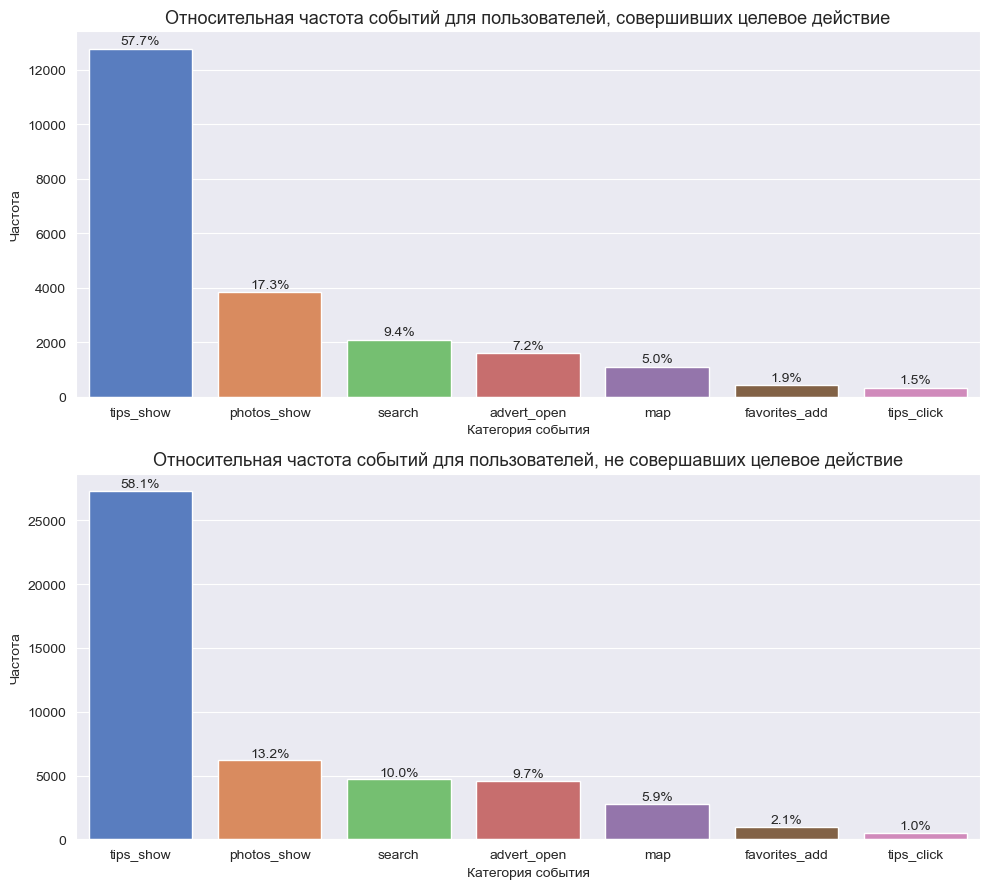

In [115]:
fig, ax = plt.subplots(2,1, figsize=(10, 9))

ax1 = sns.barplot(data=cs_users_table,
            x='event_cat',
            y='cnt',
            ax=ax[0])
for n,p in enumerate(ax1.patches):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h + 500)
    text = f'{cs_users_table.loc[n,"perc"]:0.1f}%'
    ax1.annotate(text=text, xy=xy, ha='center', va='top')
    
ax1.set_title('Относительная частота событий для пользователей, совершивших целевое действие',
             fontsize=13)
ax1.set_xlabel('Категория события')
ax1.set_ylabel('Частота')
    
ax2 = sns.barplot(data=non_cs_users_table,
            x='event_cat',
            y='cnt',
            ax=ax[1])
for n,p in enumerate(ax2.patches):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h + 1000)
    text = f'{non_cs_users_table.loc[n,"perc"]:0.1f}%'
    ax2.annotate(text=text, xy=xy, ha='center', va='top')
    
ax2.set_title('Относительная частота событий для пользователей, не совершавших целевое действие',
             fontsize=13)
ax2.set_xlabel('Категория события')
ax2.set_ylabel('Частота')
    
fig.tight_layout();


- Пользователи совершающие целевые действия почти так же часто видят рекомендации - почти 58% действий для обеих групп, при этом они реже открывают карточки объявлений (2,5% разниа), чуть реже открывают карту и пользуются поиском (здесь разница меньше 1%).
- При этом пользователи, совершающие целевые действия чаще смотрят фотографии - 17,3 % против 13,2% - что в целом может свидетельствовать о большей заинтересованности в товаре и несколько чаще нажимают на рекомендации. 

#### Выводы
1. Пользовательские сессии с целевым действием оказались длительнее сессий без целевого как по среднему, так и по медиане, разница в среднем времени сессии при этом составила порядка 4-5 минут.
2. Пользователи, совершающие целевое действие, значительно чаще смотрят фотографии в объявлениях и значительно реже видят рекомендации.
3. Кроме того, они чаще добавляют в избранное, чуть чаще кликают на рекомендации и чуть реже смотрят карту и карточки объявлений. Все это, кроме, пожалуй, последнего пункта свидетельствует о том, что пользователи из первой гурппы больше склонны к покупке. 

### Проверка гипотез

В процессе анализа одной из наших задач является проверка двух гипотез.

#### Гипотеза № 1

В рамках данной гипотезы мы рассмотрим конверсии в целевое действие двух групп пользователей: пользователей, которые только просматривают рекомендации (`tips_show`) и пользователей, которые просматривают рекомендации и кликают на них (`tips_show` + `tips_click`).

**Нулевая гипотеза (Н0)** состоит в том, что конверсии у этих двух групп равны. \
**Альтернативная (Н1)** говорит о том, что конверсии различаются.

Установим уровень статистической заничимости на отметке 0.05. 

Для проведения статистического теста разделим нашу выборку на две группы: те, кто совершают `tips_click` и те, кто совершают только `tips_show`.\
Для пользователей каждой группы определим, совершали ли они целевое действие. Если совершали - то присвоим 1, если нет, то 0. Среднее по получившемуся столбцу и будет нашей конверсией пользователя в целевое действие, его мы будем использовать при проведении статистического теста. 

In [116]:
#определяем id пользователей, совершающих только `tips_click` или только `tips_show
tc_user_id = df.loc[df['event_cat'] == 'tips_click', 'user_id']
non_tc_user_sessions = df[~df['user_id'].isin(tc_user_id)]
ts_user_id = non_tc_user_sessions.loc[non_tc_user_sessions['event_cat'] == 'tips_show', 'user_id']

#извлекаем пользователей для каждой группы, определяем, есть ли целевое действие
    #если есть - 1, если нет то - 0
tc_user_sessions = df[df['user_id'].isin(tc_user_id)]
tc_user_agg = (
    tc_user_sessions
    .groupby('user_id')
    .agg({'event_cat': lambda x: 1 if "contacts_show" in list(x) else 0})
    .reset_index()
)

ts_user_sessions = df[df['user_id'].isin(ts_user_id)]
ts_user_agg = (
     ts_user_sessions
    .groupby('user_id')
    .agg({'event_cat': lambda x: 1 if "contacts_show" in list(x) else 0})
    .reset_index()
)

print(f'''Конверсия для группы `tips_click` равна {round(tc_user_agg['event_cat'].sum()/
tc_user_agg['event_cat'].count()*100, 2)}%''')

print(f'''Конверсия для группы `tips_show` равна {round(ts_user_agg['event_cat'].sum()/
ts_user_agg['event_cat'].count()*100, 2)}%''')

Конверсия для группы `tips_click` равна 31.06%
Конверсия для группы `tips_show` равна 16.97%


На первый взгляд конверсии значительно различаются - конверсия группу `tips_click` кажется значительно выше. Проверим, что это действительно так, проведя статистический тест.

In [117]:
alpha = 0.05

results = st.ttest_ind (tc_user_agg['event_cat'],
                        ts_user_agg['event_cat'])


print('p-значение:', results.pvalue)

if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.570039017966249e-10
Отвергаем нулевую гипотезу


Конверсии действительно значительно различаются. Это значит, что те, кто просматривает рекомендации чаще совершают целевое действие. а значит гораздо более интересны приложению.

#### Гипотеза № 2

В рамках второй гипотезы мы рассмотрим тех пользователей, которые используют поиск при работе с приложением. Можно предположить, что те, кто пользуются поиском, т.е. используют действие `search`, целенаправленно заходят в приложение, чтобы что-то приобрести, а значит их конверсия в целевое действие должна быть выше. 

**Нулевая гипотеза Н0** состоит в том, что конверсия пользователей, которые совершают и не совершают действие категории `search` одинакова.
**Альтернативная гипотеза Н1** - конверси пользователей, совершающих действие `search` выше, чем остальных.

Уровень статистической значимости примем за 0.05.

Вся последовательность действие при проверке гипотез будет аналогична предыдущему шагу.

In [118]:
#определяем id пользователей, совершающих `search`
search_user_id = df.loc[df['event_cat'] == 'search', 'user_id']

#извлекаем пользователей для каждой группы, определяем, есть ли целевое действие
    #если есть - 1, если нет то - 0
search_user_sessions = df[df['user_id'].isin(search_user_id)]
search_user_agg = (
    search_user_sessions
    .groupby('user_id')
    .agg({'event_cat': lambda x: 1 if "contacts_show" in list(x) else 0})
    .reset_index()
)

non_search_user_sessions = df[~df['user_id'].isin(search_user_id)]
non_search_user_agg = (
     non_search_user_sessions
    .groupby('user_id')
    .agg({'event_cat': lambda x: 1 if "contacts_show" in list(x) else 0})
    .reset_index()
)

print(f'''Конверсия для группы `search` равна {round(search_user_agg['event_cat'].sum()/
search_user_agg['event_cat'].count()*100, 2)}%''')

print(f'''Конверсия для группы пользователей, не совершающих `search` равна {round(non_search_user_agg['event_cat'].sum()/
non_search_user_agg['event_cat'].count()*100, 2)}%''')

Конверсия для группы `search` равна 22.63%
Конверсия для группы пользователей, не совершающих `search` равна 22.99%


На первый взгляд конверсия для двух групп не различается и даже чуть ниже для группы пользователей, совершающих поиск. Проведем статистической тест.

In [119]:
alpha = 0.05

results = st.ttest_ind (search_user_agg['event_cat'],
                        non_search_user_agg['event_cat'])


print('p-значение:', results.pvalue)

if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.7826033066697369
Не получилось отвергнуть нулевую гипотезу


Статистический тест показал, что такие значения вряд ли случайны и нулевую гипотезу отвергнуть нельзя. Таким образом можно сказать с большой долей уверенности, что конверсия пользователей, который совершают поиск, не отличается от конверсии остальных пользователей, то есть все остальные действия в приложении с равным успехом могут привести к целевому действию. 

## Заключение и рекомендации

1. **Предварительная обработка данных**:
- Следует унифицировать названия событий в БД, а также привести к единому виду наименования столбцов.
- Желательно привести данные к нужному типу.
2. **Исследование**:
- Как нами уже было сказано, большое число действий `tips_show`, а также сессий, состоящих исключительно из показа рекомендаций, позволяет предположить, что **многие пользователи просто просматривают страницы с рекомендациями** в поисках чего-то интересного. При этом очень **малая доля пользователей действительно нажимает на рекомендации**, - это может быть связано как в целом с особенностями пользовательского поведения, так и с тем, что рекомендации на самом деле не соответствуют запросам пользователей.
- **Большая часть пользователей попала в мобильное приложение через "Яндекс"**, что согласуется и с активностью этих пользователей в приложении. При этом отметим, что **пользователи из "Гугла", которые находятся на третьем месте по количеству, в целом кажутся более активными и чаще совершают целевое действие, а также связанные с ним иные действия** - поиск, просмотр фото, добавление в избранное, чем пользователи из "других" источников. Можно предположить, что последние в целом менее активны.
- При анализе графиков месячной и суточной активности пользователей не было выявлено никаких аномалий, можно сказать, что активность пользователей соответсвует ожидаемой.
- Пользовательский путь зачастую очень короткий и состоит из двух-трех действий. Многие сессии начинаются не с ожидаемых действий (например, поиска или открытия карты), а с просмотра фото или контактов - возможно, такие сессии были открыты при переходе по присланной кем-то ссылке либо были начаты с момента окончания предыдущей сессии.
- **Наиболее типичный путь пользователя к целевому действию состоит из двух шагов**: это часто "поиск - просмотр контактов", "открытие карты - просмотр контактов", "просмотр фото - просмотр контактов", "открытие карточки объявления - просмотр контактов". Самый популярный вариант из трех шагов: "поиск - просмотр фото - просмотр контактов". При этом **конверсия для каждой рассмотренной двухступеньчатой воронки оказалась существенно выше, чем для трехступеньчатой. То есть чем короче путь пользователя, тем вероятнее он придет к целевому действию**.
- Конверсия разных действий в целевое для уникальных пользователей отличается. **Самая высокая конверсия оказалась у просмотра фото - 15%, далее следует нажатие на рекомендацию и открытие карты**. Однако пользователей, нажавших на рекомендацию, оказалось существенно меньше, чем остальных.  
- **Длительность сессий пользователей, просматривающих контакты, оказалась в среднем выше**, чем для тех, кто никогда не просматривал контакты. Возможно, это связано с большей вовлеченностью в процесс. При этом **такие пользователи реже видят рекомендации (или смотрят их), но значительно чаще смотрят фото и добавляют объявления в избранное**.
3. **Проверка гипотез**
Нами были проверены гипотезы о влиянии разных действий на конверсию в целевое:
- Гипотеза № 1 состояла в том, что пользователи, которые только видят рекомендации и пользователи, которые их видят и нажимают на них, имеют одинаковую конверсию в целевое действие. Эта гипотеза не подтвердилась, результаты проверки позволяют опровергнуть гипотезу. Кроме того, рассмотрение конверсий для двух групп позволяет утвержджать, что **конверсия в целевое действие для пользователей, нажимающих на рекомендации, выше, чем для тех, кто только смотрит их**.
- В рамках гипотезы №2 мы предположили, что конверсия в целевое действие у пользователей, совершающих поисковые действия, выше, чем у остальных пользователей. В качестве нулевой гипотезы нами была взята гипотеза о равенстве этих двух значений и опрвоергнуть ее не удалось. Таким образом, мы **не смогли подтвердить, что конверсии у пользователей, пользующихся и не пользующихся поиском, отличаются**.

4. **Рекомендации**
- *Источники привлечения*\
Стоит обратить внимание на источники привлечения. Пользователи яндекс и гугла более активны, а также чаще совершают целевые действия, чем пользователи из "других" источников, пользователи которых совершают несколько меньше целевых действий или связанных с ними, чем это можно ожидать из пропорции. 
- *Показ рекомендациий*\
Конверсия из просмотра рекомендаций в клики для уникальных пользователей очень низкая. Всего 10% пользователей нажимют на предлагаемые рекомендации, при этом если смотреть в общем объеме действий, то пользователи нажимают лишь на каждую 50 рекомендацию. Стоит изучить, есть ли возможность улучшить этот показатель за счет улучшения алгоритма подбора рекомендаций или иным образом. Это может позволить повысить конверсию в целевое действие, так как нами было подтверждено, что для тех, кто кликает на рекомендации, конверсия в целевое действие выше, чем для тех, кто только видит их.
- *Пользовательский путь*\
Самая высокая конверсия в целевое действие у просмотра фото. Стоит подумать о том, чтобы при создании объявления указывать пользователям на то, что фотографии повышают вероятность продажи, а также предлагать в рекомендациях больше или только объявления с фото.